# Histopathologic Cancer Detection
https://www.kaggle.com/c/histopathologic-cancer-detection

Jeremy Tran, March 29, 2018

## Intro

Applications of deep learning, especially in the area of computer vision, such as facial recognition and object identification, have seen rapid advances in the past several years, especially following the publication of the seminal paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in 2012, whose authors used the convolutional neural network (CNN) to classify images and achieved unprecedented results in the ImageNet Large Scale Visual Recognition Competition (ILSVRC) in 2012.  They attained an error rate of 15.3%, being the first team since the contest's inception to reach under 25% error rate and beating the runner-up (who got 26.3% error rate) and all other competitors by a wide margin.  Their work reinvigorated interest in deep learning for AI research, and set the CNN as the standard upon which further computer vision techniques were to be built.

It is natural then to try to extend this body of work to related fields, such as medical imaging.  In this report I adapt a CNN with recent architectural advances and deep learning techniques to identify cancer tissue in the PCam data set ([https://github.com/basveeling/pcam]), as curated by Kaggle.  The code used in this report was sufficient to generate submission entries that ranked in the top 5% of the Kaggle leaderboard at the time of this writing.

## Data Exploration and Visualization

I begin with importing the data and requisite Python libraries, and defining the usual workspace constants.   FastAI is a wrapper built around Facebook's PyTorch machine learning library, and used in the excellent FastAI course [https://course.fast.ai/].

In [1]:
from fastai.vision import *

from pathlib import Path
import os

In [2]:
path = Path('data/cancer')
train = 'train'
test = 'test'
labels = 'train_labels.csv'

In [3]:
df = pd.read_csv(path/labels)

In [4]:
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
len(os.listdir(path/test))

57458

In [5]:
df.pivot_table(index="label", aggfunc=len).sort_values('id')#.plot.bar()

,id
label,
1,89117
0,130908


The problem I am addressing with machine learning is binary classification.  There are 220,0025 images in the training dataset, of which 89,117 contain pixels identifiable as cancer cells, and 130,908 present nonmalignant cells.  The test set consists of 57,458 files.

Text(0, 0.5, 'Tumor tissue samples')

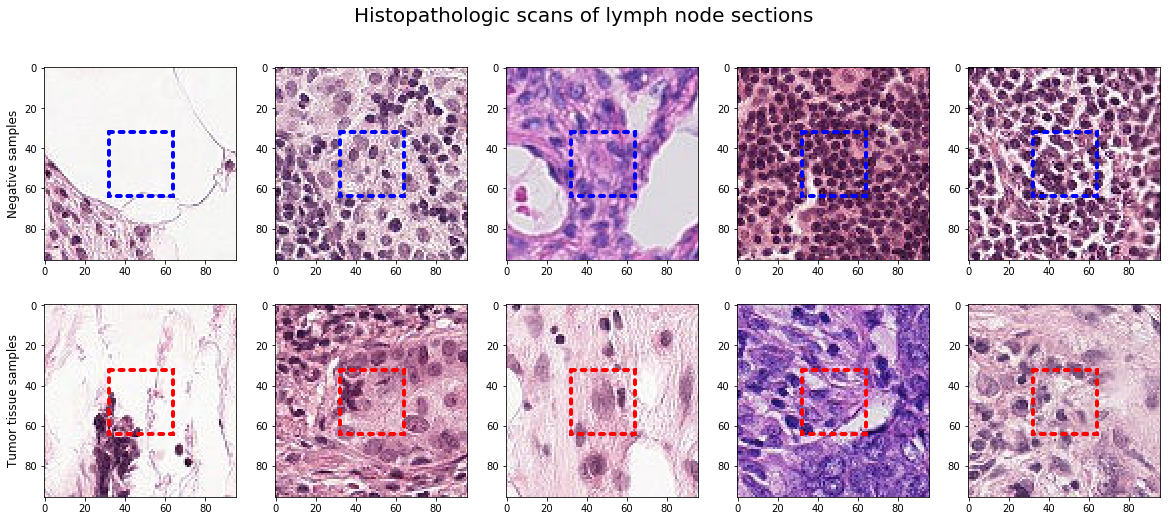

In [6]:
fnames = [str(path/train/file) +'.tif' for file in df['id']]

# courtesy of Joni Juvonen, https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
from matplotlib import patches

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

# Negatives
for i, idx in enumerate(df.index[df['label'] == 0][:5]):
    img = PIL.Image.open(fnames[idx])
    ax[0,i].imshow(img)
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(df.index[df['label'] == 1][:5]):
    img = PIL.Image.open(fnames[idx])
    ax[1,i].imshow(img)
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Here are a few images from the given dataset, with the area of interest contained within the bounding box.

### Metric: AUC Score

The metric used for this contest is the area under the ROC curve (AUC), which plots the true positive rate versus the false positive rate.  Further explanation can be found at https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [7]:
from sklearn.metrics import roc_auc_score

def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

### Data Augmentations

In order to avoid overfitting I apply augmentations to the dataset during training.  The goal of this technique is to create more data for training so that the model better regularizes to the classification problem.  Augmentations work by slightly altering the input without changing the meaning, such as flipping the image (horizontally and/or vertically, depending on the nature of the labels) or applying minor contrast/brightness adjustments.

In [8]:
p_affine = 0.75
p_lighting = 0.75

tfms = ([dihedral_affine(),
         jitter(magnitude=0.02, p=0.25),
         brightness(change=(0.4,0.6), p=p_lighting),
         contrast(scale=(0.8,1.25), p=p_lighting)],
        [crop_pad()])

In [9]:
data = ImageDataBunch.from_csv(path, train, csv_labels=labels, suffix='.tif', ds_tfms=tfms, test=test, num_workers=16, bs=42) #, size=224)

In [10]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,0,0
Path: data/cancer;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,0,1
Path: data/cancer;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data/cancer

Here's a sample image and possible transformations that may be applied to augment the image during training.

In [11]:
def get_ex(): return open_image(fnames[4041])

def plots_f(rows, cols, width, height, **kwargs):
    fig, axes = plt.subplots(rows, cols, figsize=(width, height))
    
    for i, ax in enumerate(axes.flat):
        if i == 0:
            ax.set_title('original', fontsize=14)
            get_ex().show(ax=ax)
        elif i == 1:
            get_ex().apply_tfms(tfms[1], **kwargs).show(ax=ax)
        else:
            get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax)

## Training and Fine-Tuning Models

Developing a model and fine-tuning parameters to get the best predictions while avoiding overfitting is a bit of a dark art.  A recent article even refers to such techniques as a ["bag of tricks"](https://arxiv.org/abs/1812.01187); as developments in deep learning have advanced, how to wield the bag of tricks is as important as the tricks contained within.

Ultimately my methods could be considered an ensemble technique as I average the probabilities from multiple separate architectures, the details and implementations of which may be too detailed for this report, but links for further reading have been provided.  It should be noted that this ensembling is a distinct technique from ensemble machine learning methods such as random forests.
  
### 1cycle policy and general training methodology

The training methods I use for this contest reflect some of the recent work done with regard to learning rates.  With the 1-cycle policy in [Leslie N. Smith's paper](https://arxiv.org/abs/1803.09820) (2018), learning rate is ramped up then decreased while the model is iterating through the training cycles.  The goal is twofold: to speed up training by decreasing usage of unnecessarily low learning rates; and to better regularize the model against overfitting by using higher learning rates to bypass local minima.

To initiate training a model in this way, a learning rate is found via preliminary training cycles during which learning rate is increased until the loss function values ramp up exponentially.  Choosing the point at which to set the max learning rate depends upon the practitioner and characteristics of the model and data.  The rate can be calculated or.."eyeballed" (remember, dark arts), usually where the model is still seeing decreasing training loss.  This method was also developed by Leslie Smith.

Transfer learning is an invaluable component to developing deep learning models, and thus I rely on the extensive work by previous contributors to Torchvision for this contest.  All chosen architectures have been pre-trained on ImageNet data, and to take advantage of transfer learning I initially train only the final layer for each model before allowing backpropagation through all of the layers.

Note: if the reader wishes to run these models, it is advised to clear the GPU in between switching neural networks.  Details here: [Working with GPU](https://docs.fast.ai/dev/gpu.html#gpu-memory-notes).
  
### resnet50

The first architecture I use is Microsoft's ResNet ([Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)), winner of ILSVRC 2015.  ResNet is capable of creating very deep networks without suffering from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) that tends to happen with adding a lot of layers to neural networks.  ResNet creates residual blocks with skip connections that bypass layers, such as an identity shortcut that performs identity mapping.

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, auc_score])

1e-2 looks like a good rate to me.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


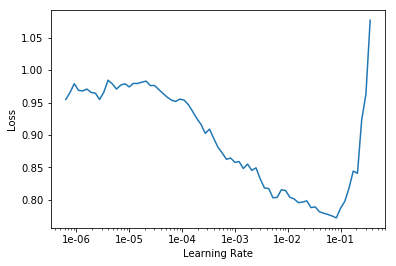

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.275880,0.231880,0.910533,0.965783,07:13
1,0.200916,0.155850,0.943643,0.982862,07:13


Here is how the learning rate varies across the two epochs run.

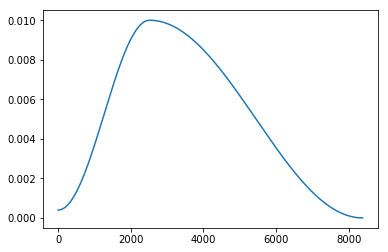

In [16]:
learn.recorder.plot_lr()

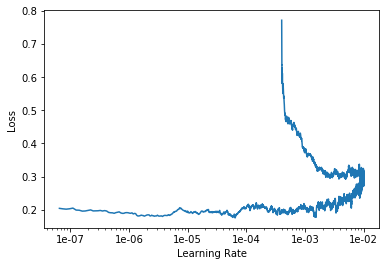

In [17]:
learn.recorder.plot()

Validation loss keeps decreasing, so the model seems to be generalizing well.

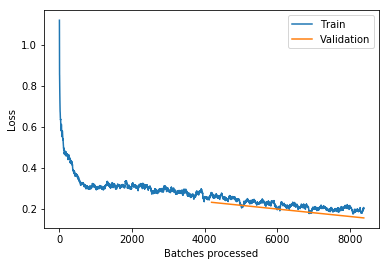

In [18]:
learn.recorder.plot_losses()

Now I train the rest of the layers.  With the fastai library, differential learning rates across layers is enabled by passing a slice to the learning rate parameter.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


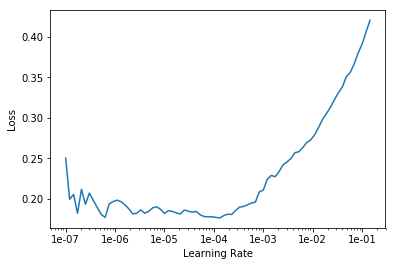

In [61]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_start=0)

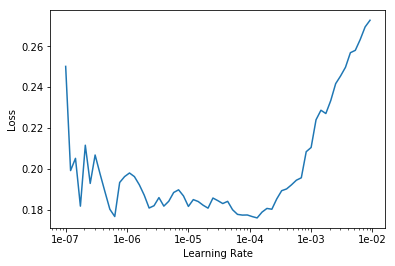

In [62]:
learn.recorder.plot(skip_start=0, skip_end=20)

In [63]:
learn.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.176538,0.140862,0.948210,0.986179,08:53
1,0.162588,0.133555,0.950892,0.987454,08:54


Further training and tuning of hyperparameters is where murky water territory lies, and who knows what the optimal path to take is from here.  I rely on an assessment of training vs validation loss and scoring metrics to choose to go further and avoid the pitfalls of overfitting and model divergence while striving for regularization.

In [66]:
learn.fit(10, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.159516,0.130732,0.951392,0.987988,08:54
1,0.153893,0.129291,0.952301,0.988414,08:54
2,0.158552,0.126446,0.953233,0.988766,08:54
3,0.156776,0.125361,0.954210,0.989084,08:54
4,0.161053,0.120959,0.955391,0.989834,08:54
5,0.147204,0.120649,0.955550,0.989748,08:54
6,0.153076,0.118477,0.955596,0.990163,08:54
7,0.144984,0.116263,0.957119,0.990654,08:54
8,0.145998,0.116111,0.956687,0.990493,08:54
9,0.126024,0.113484,0.958027,0.990986,08:54


In [79]:
learn.fit(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.128279,0.113616,0.958096,0.990962,06:39
1,0.145559,0.113268,0.958005,0.991065,06:40
2,0.140545,0.112798,0.958232,0.991058,06:40
3,0.135335,0.112501,0.958323,0.991065,06:40
4,0.135034,0.112952,0.958187,0.991034,06:40


### Predictions

Similar in principle to augmentation during training, test-time augmentation (TTA) during validation and testing tries to create better predictions by running multiple augmentations of each test or validation image through the model, then taking the average of the results.


In [19]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [20]:
predictions = to_np(preds)[:,1]

In [12]:
def write_preds(predictions, subm_file):
    ids = [os.path.splitext(i)[0] for i in os.listdir(path/test)]
    preds_df = pd.DataFrame({'id':ids, 'predict':predictions})
    sample_df=pd.read_csv(path/'sample_submission.csv')
    submit_df = sample_df.merge(preds_df, on='id').drop('label', axis=1).rename(columns={'predict':'label'})
    submit_df.to_csv(path/subm_file, header=True, index=False)

The Kaggle automated scoring systems seems to rate each prediction in the submission file by the same order that the labels were given in the sample file, as opposed to actually matching each label with the corresponding predicted probability, so I reorder my csv output accordingly.  This entry scored 0.9713 on Kaggle.

In [1]:
write_preds(predictions, 'submission-0309-rn.csv') # 0.9713

### densenet201

Similar to ResNets, DenseNets ([Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993), 2016) also address the vanishing gradient problem, but by directly connecting all layers with each other.  By concatenating feature maps from earliers layers to subsequent layers, DenseNet reuse features and reduce the number of parameters needed as with ResNets.  For my purposes, it is sufficient that the architecture has a different neural network foundation than ResNet, and is thus worth testing.  Also, it seemed to be favored in discussions amongst other Kagglers for some reason.

The following cells feature different hyperparameter values than I would have used but well... it seemed to work for them, so I gave it a shot.

In [20]:
learn = cnn_learner(data, models.densenet201, metrics=[accuracy, auc_score])

/home/jimey/miniconda3/envs/dl/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


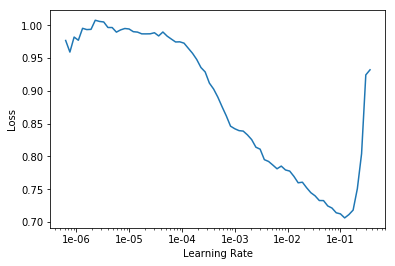

In [19]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.297954,0.213839,0.915419,0.965412,14:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


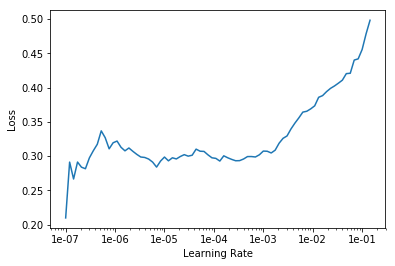

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_start=0)

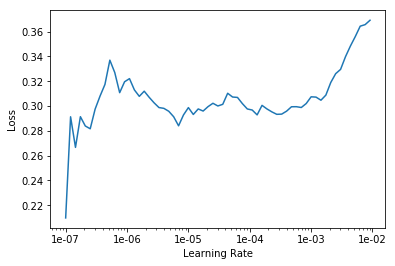

In [22]:
learn.recorder.plot(skip_start=0, skip_end=20)

In [23]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.185680,0.148332,0.945188,0.982400,15:21
1,0.168811,0.138868,0.950324,0.985464,15:22
2,0.146554,0.113307,0.961777,0.989714,15:24
3,0.136771,0.111875,0.961391,0.991021,15:23
4,0.113293,0.100561,0.965708,0.992351,15:23
5,0.094613,0.086355,0.970753,0.993980,15:23
6,0.078559,0.083384,0.972571,0.994290,15:23
7,0.064681,0.075145,0.975003,0.995410,15:23
8,0.057610,0.071921,0.976571,0.995787,15:24
9,0.053181,0.071162,0.977207,0.995987,15:24


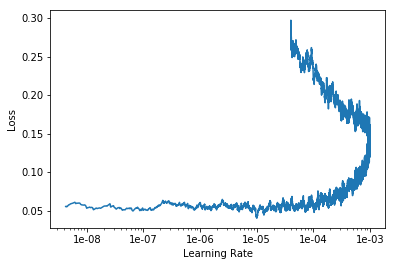

In [24]:
learn.recorder.plot()

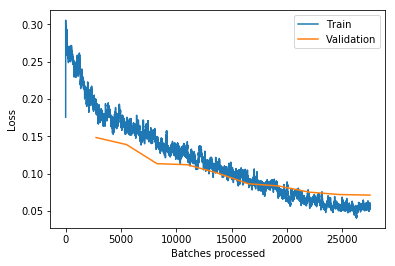

In [25]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


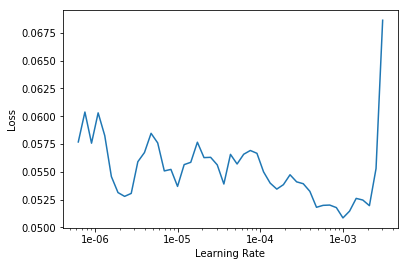

In [26]:
learn.lr_find()
learn.recorder.plot()

In [148]:
learn.fit(10, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.142775,0.116606,0.959186,0.990279,15:19
1,0.134817,0.109497,0.960936,0.991343,15:21
2,0.132106,0.109750,0.961709,0.991470,15:22
3,0.125210,0.106242,0.962004,0.991901,15:21
4,0.124637,0.104809,0.962800,0.992058,15:21
5,0.114168,0.099570,0.964436,0.992826,15:21
6,0.117042,0.103261,0.964845,0.992386,15:21
7,0.106364,0.097564,0.965754,0.993255,15:21
8,0.104207,0.095564,0.966458,0.993553,15:21
9,0.104499,0.090896,0.968526,0.994193,15:21


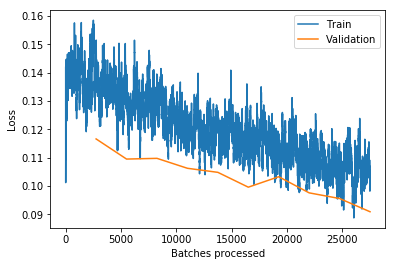

In [151]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


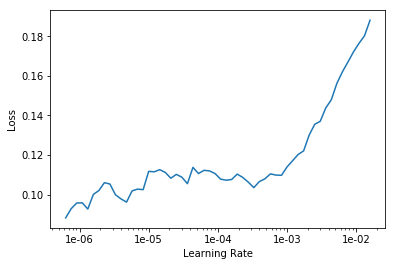

In [156]:
learn.lr_find()
learn.recorder.plot()

In [157]:
learn.fit(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.106241,0.089769,0.968254,0.994245,15:23
1,0.100427,0.089661,0.968367,0.994289,15:25
2,0.099557,0.089526,0.968754,0.994394,15:24
3,0.100577,0.089005,0.968663,0.994375,15:23
4,0.091194,0.088123,0.968754,0.994426,15:25


In [19]:
learn.fit_one_cycle(2, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.059157,0.046524,0.984729,0.998048,15:15
1,0.056009,0.046785,0.984956,0.998074,15:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


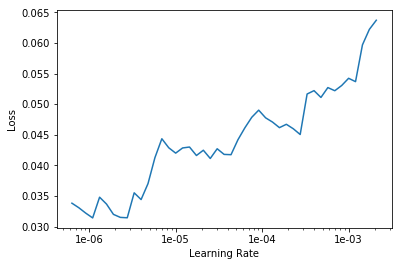

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.058306,0.046476,0.985024,0.998067,15:16
1,0.065292,0.047034,0.984729,0.998049,15:16
2,0.051869,0.046867,0.984752,0.998054,15:16
3,0.061635,0.046655,0.984956,0.998050,15:18
4,0.060140,0.046618,0.984774,0.998088,15:18


In [19]:
learn.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.057581,0.046746,0.985002,0.998271,15:10
1,0.057712,0.045557,0.984979,0.998345,15:10


In [20]:
learn.fit(2, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.050967,0.044856,0.985297,0.998367,15:09
1,0.052436,0.044526,0.985570,0.998418,15:09


In [22]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [20]:
predictions = to_np(preds)[:,1]

In [37]:
write_preds(predictions, 'submission-0320-dn201-2.csv') # 0.9685

This one scored 0.9685, despite performing better than ResNet during training and validation cycles.

### se_resnet50

The creators of SENets ([Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507), 2017) introduce a new block that can be inserted into previous models, as opposed to designing an entirely new architecture.  The authors won 1st place in ILSVRC 2017, also the last Imagenet competition ever to be held.

Each squeeze-excitation block adaptively calibrates interdependencies among channels created within a convolution block.  Without SENets, CNNs weigh each channel created from output feature maps equally.

SENet models does not come pre-packaged with torchvision, so I rely on cadene's work [https://github.com/Cadene/pretrained-models.pytorch] for the base architecture and pre-trained weights, and edit the last layers for this contest.  Training the model ensues similarly as before.

In [23]:
#pytorch implementation courtesy of cadene https://github.com/Cadene/pretrained-models.pytorch

from senet import se_resnet50
from fastai.callbacks import num_features_model

base = se_resnet50()
body = nn.Sequential(*list(base.children())[:-2])

nf = num_features_model(nn.Sequential(*body.children())) * 2
head = create_head(nf, data.c)

model = nn.Sequential(body, head)

In [24]:
def default_split(m): return (m[1],)

learn = Learner(data, model, metrics=[accuracy, auc_score])
learn.split(default_split)
learn.freeze()
apply_init(model[1], nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


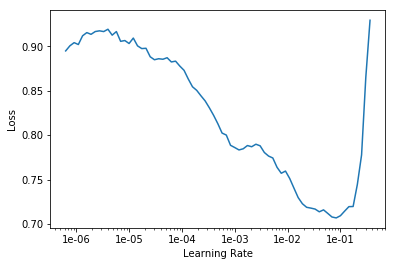

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.205192,0.207825,0.923281,0.979821,09:52
1,0.168511,0.137917,0.949051,0.986650,09:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


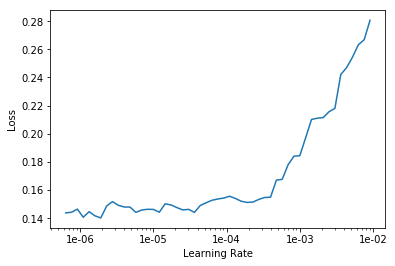

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

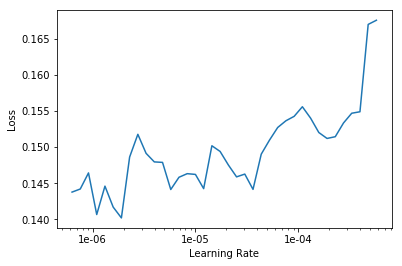

In [21]:
learn.recorder.plot(skip_end=20)

In [22]:
learn.fit_one_cycle(2, slice(2e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.165717,0.131860,0.952074,0.987183,12:26
1,0.154116,0.129348,0.952574,0.987555,12:26


In [23]:
learn.fit_one_cycle(2, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.167536,0.129043,0.953096,0.987206,12:26
1,0.149436,0.129179,0.952869,0.988023,12:26


In [25]:
learn.fit_one_cycle(2, slice(7e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.157835,0.124250,0.955187,0.988485,12:26
1,0.142035,0.118032,0.956937,0.990500,12:26


In [26]:
learn.fit_one_cycle(2, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.143025,0.115673,0.958437,0.990405,12:26
1,0.148069,0.115645,0.957732,0.989851,12:26


In [27]:
learn.fit_one_cycle(2, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.139278,0.114445,0.958096,0.990343,12:25
1,0.141559,0.114692,0.958550,0.990337,12:26


In [26]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [20]:
predictions = to_np(preds)[:,1]

In [38]:
write_preds(predictions, 'submission-0321-srn50.csv') # 0.9707

This one scored 0.9707.

### se_resnext50

The runners-up of ILSVRC 2016 ([Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431)) created ResNeXt, which added a cardinality dimension to ResNet, instead of just going deeper or wider, e.g. ResNet layer-1 has 1 conv layer with 64 width, while ResNeXt layer-1 has 32 conv layers with 4 width.  The actual winners used ensembling without introducing new architectures (much like I am doing now), but they probably would have used ResNeXt had the paper been published prior to the contest that year.

It makes logical sense to combine the best of 2016 and 2017 for my next model test.

In [28]:
from senet import se_resnext50_32x4d
from fastai.callbacks import num_features_model

base = se_resnext50_32x4d()
body = nn.Sequential(*list(base.children())[:-2])

nf = num_features_model(nn.Sequential(*body.children())) * 2
head = create_head(nf, data.c)

model = nn.Sequential(body, head)

In [29]:
def default_split(m): return (m[1],)

learn = Learner(data, model, metrics=[accuracy, auc_score])
learn.split(default_split)
learn.freeze()
apply_init(model[1], nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


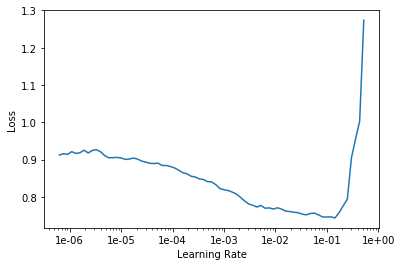

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.235739,0.191609,0.927190,0.978243,12:17
1,0.173119,0.131299,0.952937,0.986132,12:17


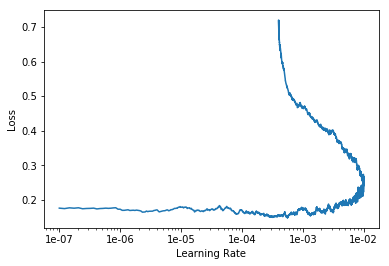

In [66]:
learn.recorder.plot()

In [67]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


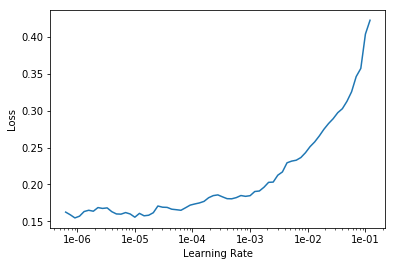

In [68]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(2,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.166995,0.128770,0.953755,0.986231,15:47
1,0.168484,0.128263,0.953869,0.985712,15:49


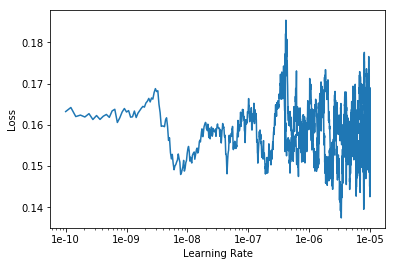

In [73]:
learn.recorder.plot()

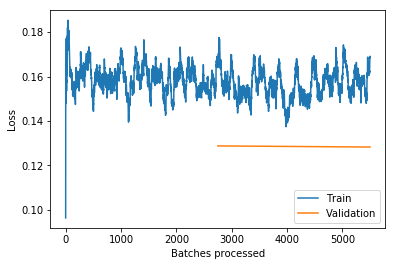

In [74]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


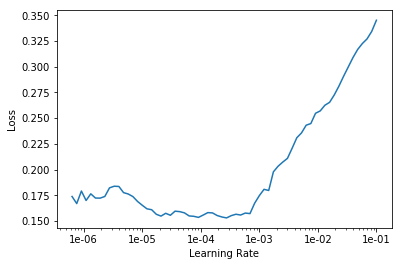

In [75]:
learn.lr_find()
learn.recorder.plot()

In [78]:
learn.fit(10,slice(1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.158072,0.124973,0.955141,0.985694,15:49
1,0.152248,0.125193,0.955846,0.986168,15:50
2,0.134423,0.120431,0.956641,0.987421,15:50
3,0.145805,0.118243,0.957278,0.987251,15:51
4,0.148001,0.116685,0.958209,0.986935,15:51
5,0.136182,0.116346,0.958368,0.988784,15:51
6,0.134020,0.113384,0.959414,0.987582,15:51
7,0.139876,0.115678,0.959982,0.989301,15:50
8,0.127659,0.136852,0.959982,0.989911,15:50
9,0.125456,0.110240,0.959959,0.989583,15:51


In [94]:
learn.fit(10,slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.129765,0.109235,0.960754,0.990049,15:46
1,0.126777,0.109508,0.960686,0.990393,15:50
2,0.127461,0.108810,0.961073,0.990088,15:50
3,0.127929,0.108986,0.960823,0.990232,15:50
4,0.131582,0.110064,0.960845,0.990201,15:50
5,0.119270,0.107509,0.961686,0.990467,15:49
6,0.125331,0.108251,0.961436,0.990243,15:50
7,0.125942,0.108529,0.961118,0.989942,15:50
8,0.124760,0.107988,0.960914,0.988556,15:51
9,0.123004,0.108022,0.961232,0.987425,15:48


In [106]:
learn.fit_one_cycle(2,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.123834,0.107144,0.961686,0.991262,15:46
1,0.130035,0.107396,0.962004,0.991087,15:50


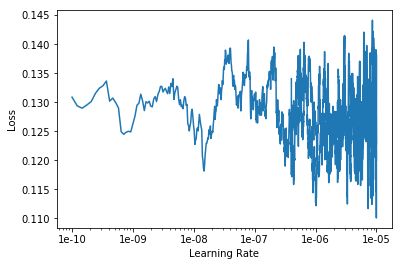

In [107]:
learn.recorder.plot()

In [112]:
learn.fit(5,slice(1e-6))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.127082,0.106298,0.962050,0.990587,15:49
1,0.123410,0.106310,0.961913,0.989954,15:51
2,0.134782,0.108064,0.962118,0.990516,15:51
3,0.124236,0.106620,0.962163,0.990329,15:51
4,0.123858,0.106468,0.961823,0.988609,15:51


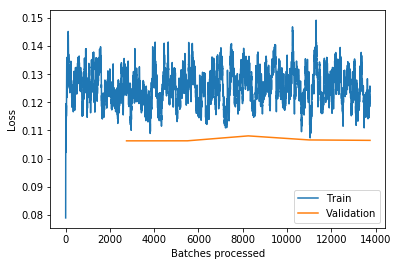

In [114]:
learn.recorder.plot_losses()

In [30]:
learn.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.127065,0.098114,0.965913,0.990756,15:52
1,0.108409,0.098580,0.968004,0.992982,15:52


In [31]:
learn.fit_one_cycle(2, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.109675,0.091496,0.968345,0.991619,15:51
1,0.102503,0.093316,0.968299,0.991582,15:52


In [31]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [20]:
predictions = to_np(preds)[:,1]

In [39]:
write_preds(predictions, 'submission-0320-srnx50.csv') # 0.9732

This model performed the best thus far, scoring 0.9732.

### senet154

The creators of SENets used an ensemble of models to create their winning entry in ILSVRC.  SENet-154 was their strongest-performing single model from that ensemble, and was created by modifying ResNeXt152.  This model was the last one that I tried, and turned out to be very computationally expensive, as evidenced by the training times below, e.g. 70 min for one epoch after unfreezing all layers, vs about 16 min per epoch for the next most demanding model, SE_ResNeXt50.  However, the authors used 8 servers with 64 GPUs to train their models; I have 1 server composed of used parts and 1 pre-2017 GPU.

In [32]:
from senet import senet154
from fastai.callbacks import num_features_model

base = senet154()
body = nn.Sequential(*list(base.children())[:-3]) # senet154 adds an additional dropout layer prior to classification

nf = num_features_model(nn.Sequential(*body.children())) * 2
head = create_head(nf, data.c)

model = nn.Sequential(body, head)

In [33]:
def default_split(m): return (m[1],)

learn = Learner(data, model, metrics=[accuracy, auc_score])
learn.split(default_split)
learn.freeze()
apply_init(model[1], nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


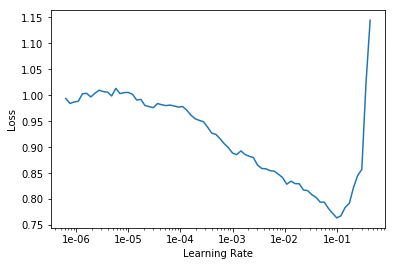

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.183590,0.355819,0.938552,0.982309,48:33
1,0.126829,0.112699,0.960914,0.988088,48:36


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


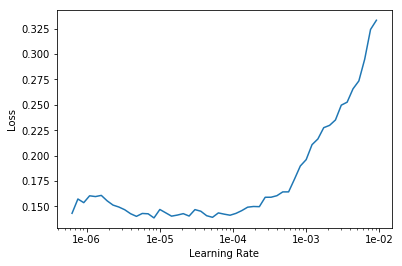

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

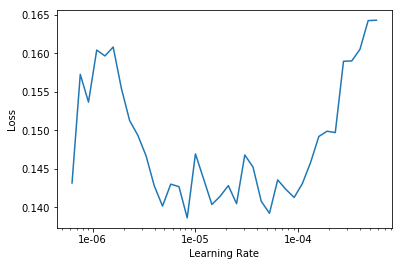

In [17]:
learn.recorder.plot(skip_end=20)

In [18]:
learn.fit_one_cycle(2, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.121567,0.100366,0.965118,0.992820,1:10:25
1,0.128030,0.175426,0.964231,0.991876,1:10:26


In [36]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

In [20]:
predictions = to_np(preds)[:,1]

In [40]:
write_preds(predictions, 'submission-0324-154.csv') #w0.9714

## Submissions and Ensembling

There are a number of ways to average results of this nature, such as calculating a geometric mean, or weighing by rank... Since all the models generated the same type of outputs, i.e. probability values between 0 and 1, I found a simple average with somewhat arbitrary weights worked best for me.  My best ensemble scored .9773, a substantial increase of the AUC score over any single model.

In [3]:
df1 = pd.read_csv(path/'submission-0309-rn.csv')   #0.9713
df2 = pd.read_csv(path/'submission-0320-dn201-2.csv') # 0.9685
df3 = pd.read_csv(path/'submission-0321-srn50.csv') # 0.9707
df4 = pd.read_csv(path/'submission-0320-srnx50.csv') #0.9732
df5 = pd.read_csv(path/'submission-0324-154.csv') # 0.9714

In [4]:
# 0.9773
en11 = df1.copy()
en11['label'] = 0.2*df1['label'] + 0.2*df2['label'] + 0.1*df3['label'] + 0.3*df4['label'] + 0.2*df5['label']

In [5]:
en11.to_csv(path/'submission-0328-ensemble-6.csv', header=True, index=False)

## Beyond Kaggle

As seen above by the extensive experimentation and excessive iterations run over slightly modified hyperparameters, preparing for a Kaggle contest is quite different than a production setting.  In striving for that less than 0.1% increase in scoring (which still amounts to give or take, 50 images), I essentially utilize more than five times the time and resources that it would have taken to utilize only a single model.  However, for larger organizations with the computing power, that marginal improvement may be worth the effort, and indeed ILSVRC 2016 was won not with fancy new models, but the ensembling of different, existing known models.

In the ongoing quest for automated machine learning (AutoML), ensembling and other ugly, computationally complex or inelegant solutions may rise to the fore from unsupervised computing processes.  For instance, the H2O platform offers automated grid search through thousands of machine learning models as well as their hyper-parameters, and automated functionality to stack ensembles of the best-fitting methods found to form...massive, well-peforming "Frankenstein models."

Neural architectural search, as the underlying bases of NASNets, take this automation one step further by allowing the algorithm to find the best neural network layers. However, when I tried to implement Nasnet for the histopathologic cancer detection contest, I kept running out of GPU memory.  Even the more optimized progressive neural architecture search network (PNASNet) would not run with minimal batch sizes set.  AutoML may be the future, but it does not come freely, and it most likely will require human expertise to best utilize its benefits.  Eventually, a more efficient architecture may be found from the expensive process of finding architectures, at which point it would still require human expertise to apply transfer learning to apply this better architecture to automate future data modeling and architecture finding and model fitting and so on...

Even with the best automated methods and brightest minds, the most important part of data science is still the data.  Problems such as data leakage into datasets can still occur, creating inherent biases and potentially invalidating statistically sound conclusions.  As it so happens, this cancer detection contest actually suffered a total data leak when people figured out the file names were just generated from the sha1 hashes of the original whole slide images.  The exercise remains valid, just the contest part is not.  Care should be taken with machine learning that we are not simply confirming pre-existing notions but actually doing the science part of data science.